In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [37]:
# implement a Hopfield network in PyTorch with iterative learning
class Hopfield(nn.Module):
    def __init__(self, n_inputs):
        super(Hopfield, self).__init__()
        self.n_inputs = n_inputs
        self.W = nn.Parameter(torch.randn(n_inputs, n_inputs))
        self.W.requires_grad = False

    def forward(self, x):
        return self.W.mm(x)
    
    def train(self, pattern, lr):
        """ Train with iterative hebbian update"""
        self.W.data += lr * pattern.t().mm(pattern)
        self.W.data /= torch.norm(self.W.data)
    
    def predict(self, x):
        return (self.forward(x)>0).float()*2-1

    def evolve_till_convergence(self, x, max_iter=100, tol=1e-3):
        for i in range(max_iter):
            x_new = self.predict(x)
            if torch.norm(x_new - x) < tol:
                break
            x = x_new
        return x_new
    
testNet = Hopfield(10)
train_data = torch.tensor([[1, 1, 1, 1, 1, -1, -1, -1, -1, -1],
                            [-1, -1, -1, -1, -1, 1, 1, 1, 1, 1]], dtype=torch.float)
testNet.train(train_data, lr=1)

In [47]:
testNet.evolve_till_convergence(torch.randn(10,1))

tensor([[-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.]])

In [233]:
# Toy mushroom body model with hopfield network
n_KCs = 10
n_compartments = 2 # number of DAN MBON pairs

state_size = n_KCs + 2*n_compartments

def generate_random_odor(seed=None):
    if seed is not None:
        np.random.seed(seed)
    odor_identity = np.random.choice([-1, 1], size=n_KCs, p=[0.8, 0.2])
    odor_valence = np.random.choice([-1, 1], size=n_compartments)
    odor_outcome = -1*odor_valence
    return torch.tensor(np.concatenate([odor_identity, odor_valence, odor_outcome]), dtype=torch.float).reshape(1, state_size)

MB = Hopfield(state_size)

odors = torch.concat([generate_random_odor() for _ in range(10)])
for i in range(100):
    MB.train(odors, lr=0.1)

In [234]:
def plot_odor(state):
    fig, ax = plt.subplots(figsize=(5,5))
    KCs = [plt.Circle((0, -i + 0.5*n_KCs), 0.25, color='r', fc= 'r' if state[i]==1 else 'w',zorder=2) for i in range(n_KCs)]
    for i, KC in enumerate(KCs):
        ax.hlines(-i + 0.5*n_KCs, 0, 2+2*n_compartments, color='k')
        ax.add_artist(KC)

    MBONs = [plt.Circle((2+2*i-0.1, -0.5*n_KCs), 0.4, color='b', fc= 'b' if state[i+n_KCs]==1 else 'w',zorder=2) for i in range(n_compartments)]
    for i, MBON in enumerate(MBONs):
        ax.vlines(2+2*i-0.1, -0.5*n_KCs, 0.5*n_KCs, color='k')
        ax.add_artist(MBON)

    DANs = [plt.Circle((2+2*i+0.1, 0.5*n_KCs + 1), 0.4, color='g', fc= 'g' if state[i+n_KCs+n_compartments]==1 else 'w',zorder=2) for i in range(n_compartments)]
    for i, DAN in enumerate(DANs):
        ax.vlines(2+2*i+0.1, 0.5*n_KCs + 1, -0.5*n_KCs+1, color='k')
        ax.add_artist(DAN)

    ax.set_aspect('equal')
    ax.set_xlim(-1, 2*n_compartments+3)
    ax.set_ylim(-0.6*n_KCs, 0.7*n_KCs)

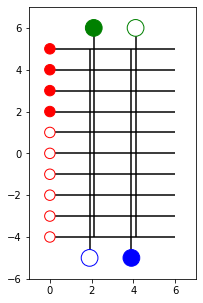

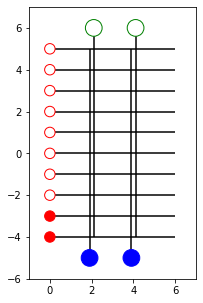

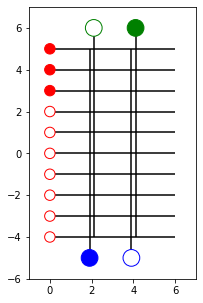

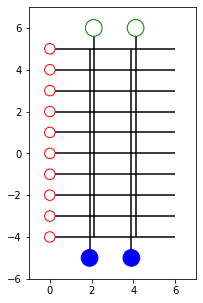

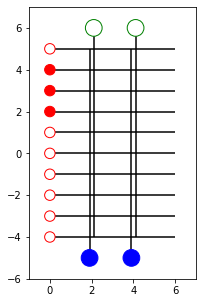

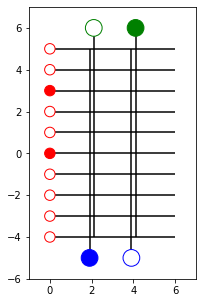

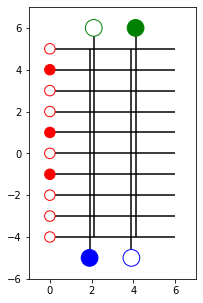

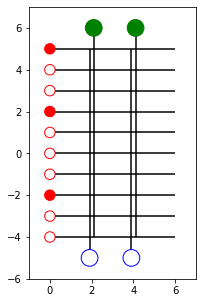

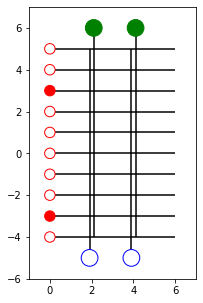

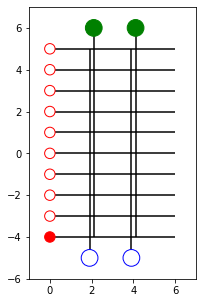

In [235]:
for i in odors:
    plot_odor(i)
    plt.show()

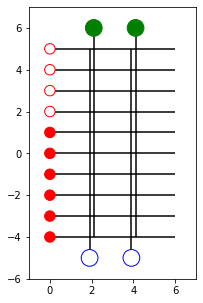

In [237]:
plot_odor(MB.evolve_till_convergence(torch.randn(state_size,1)))